## Polynomial fitting (FLAC)
The TOD of LiteBIRD is dominated by T/P leakage component. We thus developped a fitting consisting of a sine term plus a constant for whitening the TOD before encoding. Here, we consider how much compression we can expect if we apply a more generic polynomial fitting.

### Referennce 
* Maxim van den Berg (2020), Bachelor thesis Mathematics and Computer Science
"Linear predictive coding and Golomb-Rice codes
in the FLAC lossless audio compression codec"
algoritum 2.18 (solved the equation with modified Levinson-Durbin approximation)

In [1]:
############################################################
# Imports
############################################################
import numpy as np
import copy
import math
import argparse
from scipy.ndimage import convolve1d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import random

In [2]:
def load_data(infile):
    data = np.load(infile)['arr_0']
    print("Data loaded from {}".format(infile))
    return data

#----------------------------------------------------------------------                            
def save_data(outfile, data):
    np.savez(outfile, data)
    print("Data saved in {}.".format(outfile))



### Linear prediction
For the singal ${x(n)}$ at the $n$th sample, we predict its value based on $p$ previous values as follows.
\begin{equation}
y(n)=a_1x(n-1)+ ... +a_px(n-p).
\end{equation}

The optimal coefficients ($a_i$) are obtained to minimize the error
\begin{equation}
e(n)=x(n)-\sum_{i=1}^pa_ix(n-i).
\end{equation}

Since $y(n)$ and $x(n-j)$ are uncorrelated, 
\begin{equation}
E(e(n)\cdot x(n-j))=0
\end{equation}
for $1\leq j\leq p$, this equation yields
\begin{equation}
E(\sum_{i=1}^p a_i x(n-i)x(n-j))=E(x(n)x(n-j)).
\end{equation}

Now, we difine the right hand side as $\gamma(j)$. Then, the probelm is to solve the following linear coupled equation:
\begin{equation}
\begin{pmatrix}
\gamma(0) & \gamma(1) & ... & \gamma(p-1)\\
\gamma(1) & \gamma(0) & ... & \gamma(p-2)\\
. & .& .& .\\
. & .& .& .\\
. & .& .& .\\
\gamma(p-1) & \gamma(p-2) & ... & \gamma(0)\\
\end{pmatrix}
\begin{pmatrix}
a_1\\
a_2\\
.\\
.\\
.\\
a_p\\
\end{pmatrix}=
\begin{pmatrix}
\gamma(1)\\
\gamma(2)\\
.\\
.\\
.\\
\gamma(p)\\
\end{pmatrix}.
\end{equation}
Here, the matrix if all 2p − 1 diagonals is called Toeplitz.
For Toeplitz matrix,
the efficient Levinson-Durbin algorithm can be used to
solve linear systems of the form $Ta=y$ for unknown $a$.
With this approximation, we can modify the equation as
\begin{equation}
\begin{pmatrix}
\gamma(0) & \gamma(1) & ... & \gamma(p)\\
\gamma(1) & \gamma(0) & ... & \gamma(p-1)\\
. & .& .& .\\
. & .& .& .\\
. & .& .& .\\
\gamma(p) & \gamma(p-1) & ... & \gamma(0)\\
\end{pmatrix}
\begin{pmatrix}
1\\
a_1\\
a_2\\
.\\
.\\
.\\
a_p\\
\end{pmatrix}=
\begin{pmatrix}
V\\
0\\
0\\
.\\
.\\
.\\
0\\
\end{pmatrix}
\end{equation}
where we add the (unknown) variable $V$ to the linear equation.
Writing $a^{(m)}$ for
the coefficient vector including the additional 1, this reformulation allows for the unification
of the forward vector $f^{(m)}$ and coefficient vector $a^{(m)}$
, apart from a factor $V^{(m)}$ which
satisfies $T^{(m)}a^{(m)}=V^{(m)}e_1^{(m)}$. Consequently,
\begin{equation}
a^{(m+1)}=V^{(m+1)}f^{(m+1)}=\frac{V^{(m+1)}}{\eta_f^2-1}\left(-[f^{(m)} \ \ 0]+\eta_f[0 \ \ \bar{f^{(m)}}]\right)
=\frac{V^{(m+1)}}{V^{(m)}(\eta_f^2-1)}\left(-[a^{(m)} \ \ 0]+\eta_f[0 \ \ \bar{a^{(m)}}]\right)
\end{equation}
Additionally, there is the extra requirement for $a^{(m+1)}= V^{(m+1)}f_1^{(m+1)}= 1$, which we
respect by choosing $V^{(m+1)} =(1 − \eta^2_f)V^{(m)}$ such that
\begin{equation}
a^{(m+1)}=[a^{(m)} \ \ 0]-\eta_f[0 \ \ \bar{a^{(m)}}].
\end{equation}
Finally,
\begin{equation}
\eta_f=\sum_{i=1}^m\gamma(m+1-i)f_i^{(m)}=\sum_{i=1}^m\gamma(m+1-i)\frac{a_i^{(m)}}{V^{(m)}},
\end{equation}
which we can present the modified algorithm.

In [3]:
def calc_col(data, gap):
    col = 0
    for i in range(int(len(data))-gap):
        col += data[i]*data[int(i+gap)]
    return col

def smoothing_flac(data, smo_par, p, subtract=True):
    data_new = data
    
    # calc col for the full dataset(gamma)
    gamma = []
    for i in range(p):
        gamma.append(calc_col(data[0][:], i))
    num_chunk=int(len(data[0])/smo_par)

    for j in range(num_chunk):
        # define dataset in a chunk
        Ys=copy.deepcopy(data[0][j*smo_par:(j+1)*smo_par])
        len_data = len(Ys)
        a_before = np.array([1])
        e_before = gamma[0]
        
        for m in range(p-1):
            m+=1
            k=0
            for i in range(m):
                i+=1
                k+=gamma[m+1-i]*a_before[i-1]/e_before
            e_new = (1-k*k)*e_before
            a_new = np.append(a_before, 0)-k*np.append(0, a_before[::-1])
            e_before = e_new
            a_before = a_new

        # cal
        for n in range(len_data):
            lin_pred = 0
            for k in range(p):
                lin_pred += a_before[k]*Ys[n-k]

            if (subtract is True):
                data_new[0][j*smo_par+n] = Ys[n]-lin_pred
                
            else:
                data_new[0][j*smo_par+n] = Ys[n]
                    
                    


    # Process remainders if sufficient number left.
    Ys=copy.deepcopy(data[0][(j+1)*smo_par:])
    len_data=int(len(Ys))
    if len_data>0:
        # calc gamma
        gamma = []
        for i in range(p):
            gamma.append(calc_col(Ys, i))

        #print("gamma=", gamma)
        a_before = np.array([1])
        e_before = gamma[0]

        for m in range(p-1):
            m+=1
            k=0
            for i in range(m):
                i+=1
                k+=gamma[m+1-i]*a_before[i-1]/e_before
            e_new = (1-k*k)*e_before
            a_new = np.append(a_before, 0)-k*np.append(0, a_before[::-1])

            e_before = e_new
            a_before = a_new

        # cal
        for n in range(len_data):
            lin_pred = 0
            for k in range(p):
                lin_pred += a_before[k]*Ys[n-k]

            if (subtract is True):
                data_new[0][(j+1)*smo_par+n] = Ys[n]-lin_pred
            else:
                data_new[0][(j+1)*smo_par+n] = lin_pred

    return data_new


### Simulation for random data

We first simulate a random TOD and apply the polynomial fitting. We calculated the information entropy of the input data (orange) and the residual after subtracting the fit (green).

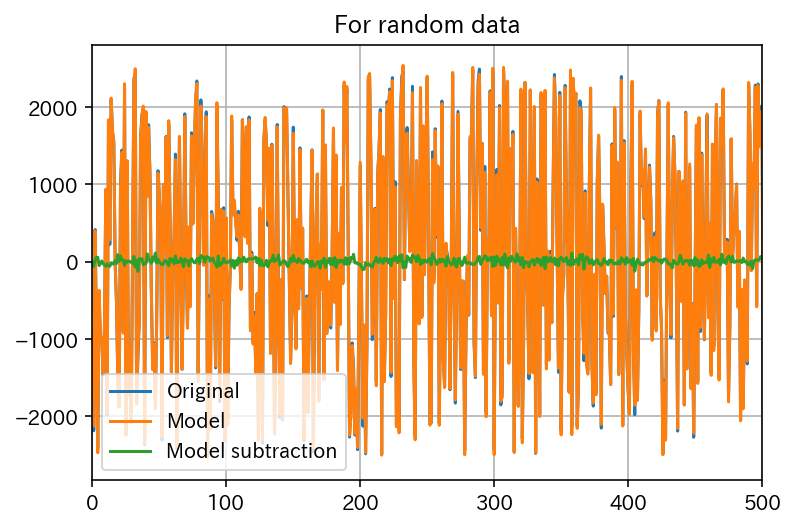

In [7]:
d=[[int(5000*(random.random()-0.5)) for i in range(10000)]] #for random data
plt.plot(d[0][:],label="Original")
d_copy=copy.deepcopy(d)

new=smoothing_flac(d_copy,1000,10, subtract=True)
plt.plot(np.array(d[0][:])-np.array(new[0][:]),label="Model")
plt.plot(new[0],label="Model subtraction")
plt.xlim([0,500])
plt.grid()
plt.legend()
plt.title("For random data")
plt.show()

### Simulation for LB TOD fitted with polynomials
We then used the LiteBIRD TOD described in Tominaga et al (LTD) and calculated the information entroy of the input data and the residual after subtracting the fit.

Data loaded from test_H00_063_U_195B_int.npz


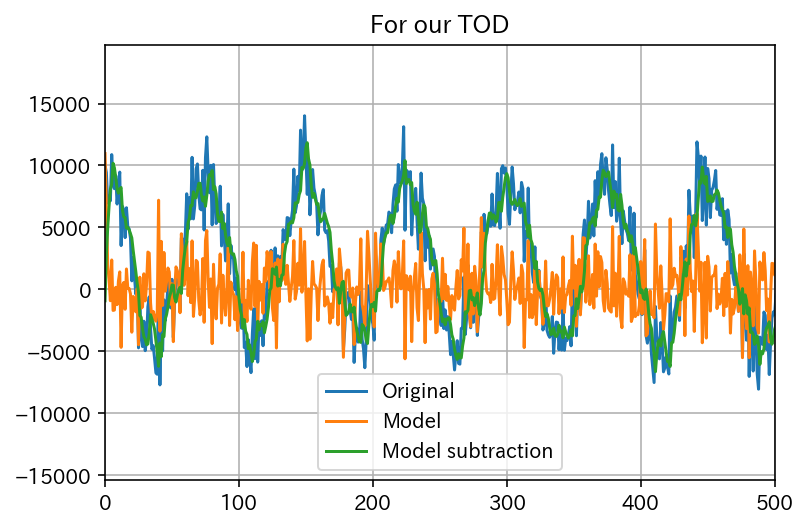

In [6]:
f_name="test_H00_063_U_195B_int.npz"
d=load_data(f_name) #for our TOD
plt.plot(d[0][:],label="Original")
d_copy=copy.deepcopy(d)

new=smoothing_flac(d_copy,1000,10, subtract=True)
plt.plot(np.array(d[0][:])-np.array(new[0][:]),label="Model")
plt.plot(new[0],label="Model subtraction")
plt.xlim([0,500])
plt.grid()
plt.legend()
plt.title("For our TOD")
plt.show()

### Simulation for LB TOD fitted with sine
We next applied the sine + constant model as written in the proceeding.
We calculated the information entroy of the input data and the residual after subtracting the fit for some "p" using in FLAC algorithm.
The entropy is more than 14 bits with the fitting penalty.

In [3]:
from IPython.display import display_pdf
filename = "H00_063_U_195B_tpleak1000.pdf"
with open(filename,"rb") as f:
    display_pdf(f.read(),raw=True)

### Conclusion

For the LB TOD, the sine + constant model fitted better than the polynomial fitting. This is because the polynomials are not adequate to represent the sinusoidal curve.

We will implement both fitting in the MDU and make it selectable by commands (with variable parameters), so that we can cope with unexpected results. This was briefly added in the LTD proceedings.